# Import libraries

In [81]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from scipy.stats import shapiro
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Read needed data and set varibles

In [4]:
train = pd.read_csv("../train.csv", names=["dates", "target"], header=0)
init_shape = train.shape
train["dates"] = pd.to_datetime(train["dates"], dayfirst=True, format="mixed")

# Check dates consistency

In this section I want to solve the following questions:
- How many points do we have?
- Are there any gaps between dates?
- Data contains strange dates?
- What will be the number of points used to train, test and validate the solution?

## How many points do we have?

In [5]:
print(f"The data contains {init_shape[0]} rows and {init_shape[-1]} columns.")

The data contains 86 rows and 2 columns.


In [6]:
print(f"The data contains {init_shape[0] - train.dropna().shape[0]} null rows.")

The data contains 12 null rows.


In [7]:
train.tail(13)

,dates,target
73,2021-02-01,2.9674
74,NaT,NaN
75,NaT,NaN
76,NaT,NaN
77,NaT,NaN
78,NaT,NaN
79,NaT,NaN
80,NaT,NaN
81,NaT,NaN
82,NaT,NaN


After a simple sight into the tail of the data I can confirm that those 12 points are related with the 12 points of future forecasting of the objective, so we proceed to drop them.

In [8]:
train = train.dropna()

In [9]:
print(f"After this cleaning the data contains {train.shape[0]} rows and {train.shape[-1]} columns.")

After this cleaning the data contains 74 rows and 2 columns.


This is aligned with the description of the problem.

## Are there any gaps between dates?

Finding gaps between dates could derived in bad forecasting performance and should be fixed by filling them by simple regression, by propagating the last valid value or at least by filling with the median value to not impact on the distribution.

In [10]:
number_of_data_days = train["dates"].dt.day.unique()
print(f"The days we have data are {number_of_data_days}.")

The days we have data are [1].


This is that every point corresponds with the first day of the month.


Let's see how many points do we have trough the years.

In [11]:
train.groupby(train["dates"].dt.year).size()

dates
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021     2
dtype: int64

In [12]:
train.tail(3)

,dates,target
71,2020-12-01,1.97353
72,2021-01-01,2.19952
73,2021-02-01,2.96740


After this analysis we can see that we have 12 points (one data point per month) for every year between 2015 and 2020 and 2 data points (January and February) for 2021. This is that **we don't have gaps between dates**.

## Data contains strange dates?

The short answer is no.

The long answer is after seeing the previous groupby (we have 12 points per year, which is one data point per month) and also after not getting any error in the `pd.to_datetime` method. We don't have strange dates in the data.

## What will be the number of points used to train, test and validate the solution?

The aim of the problem is to forecast the 12 next points from 01.03.2021 till 01.02.2022. To keep closer to that the approach will be the following:
1. In the first step I am going to use for training a model data from 01.01.2015 to 01.02.2019 and I am going to use for testting data from 01.03.2019 to 01.02.2020.
2. With the previous model ready I am going to validate the metrics training the same model with data from 01.01.2015 to 01.02.2020 and validating with data from 01.03.2020 to 01.02.2021.

With this approach I will check wich model could be the stablest one through the years or if it is better to keep the best model in terms of the tests metrics. The aim of split into train, test and validate is to not overfit the hyperparameters of the model to the test set.

# What about the target column?

In this section I want to anlyse the following topics:
- What is the plot of the TS?
- What is the distribution of the TS?
    - Is this consistent through the years?
    - What about the differenced TS?
- Is there any outlier?
- What is the TS decomposition?
- Analysis of the ACF and PACF.
- Analysis of the stationarity.

## What is the plot of the TS?

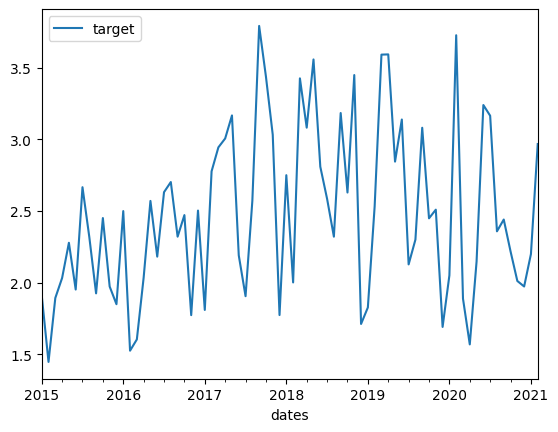

In [13]:
train.set_index("dates").plot();

## What is the distribution of the TS?

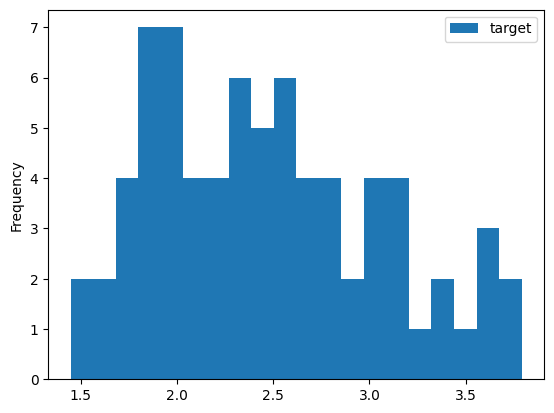

In [14]:
train.set_index("dates").plot(kind="hist", bins=20);

In [15]:
train.set_index("dates").describe()

,target
count,74.000000
mean,2.474047
std,0.593002
min,1.447330
25%,1.980592
50%,2.444870
75%,2.919247
max,3.791290


This distribution seems to show a little positive bias (right tail)

In [16]:
def plot_rolling_statistics(dataframe: pd.DataFrame, window: int, y_col: str, date_col: str) -> None:
    """This function create a 3 subplot figure with the rolling mean, std and median.

    Parameters
    ----------
        dataframe: pd.DataFrame
            Data to use in the plot.
        window: int
            Window size for the rolling calculations.
        y_col: str
            Name of the target column.
        date_col: str
            Name of the dates column.
    
    Returns
    -------
        None
            This function just plot the figure. No output is expected.
    """
    # Configure plot.
    data = dataframe.set_index(date_col)[y_col].rolling(window=window)
    _, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
    axs = axs.ravel()

    # Plot.
    axs[0].plot(data.mean(), color="blue", label=f"Windows {window} Rolling Mean")
    axs[1].plot(data.std(), color="red", label=f"Windows {window} Rolling STD")
    axs[2].plot(data.median(), color="green", label=f"Windows {window} Rolling Median")

    # Plot look'n'feel.
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

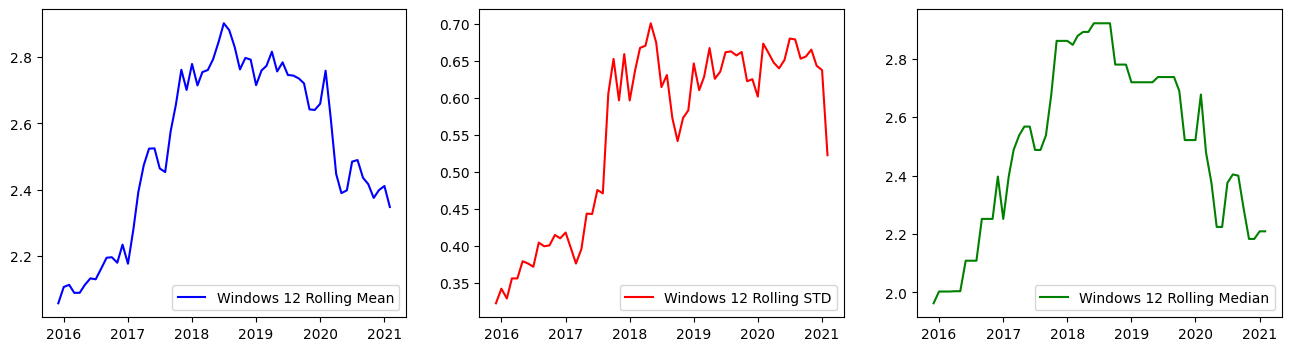

In [17]:
plot_rolling_statistics(dataframe=train, window=12, y_col="target", date_col="dates")

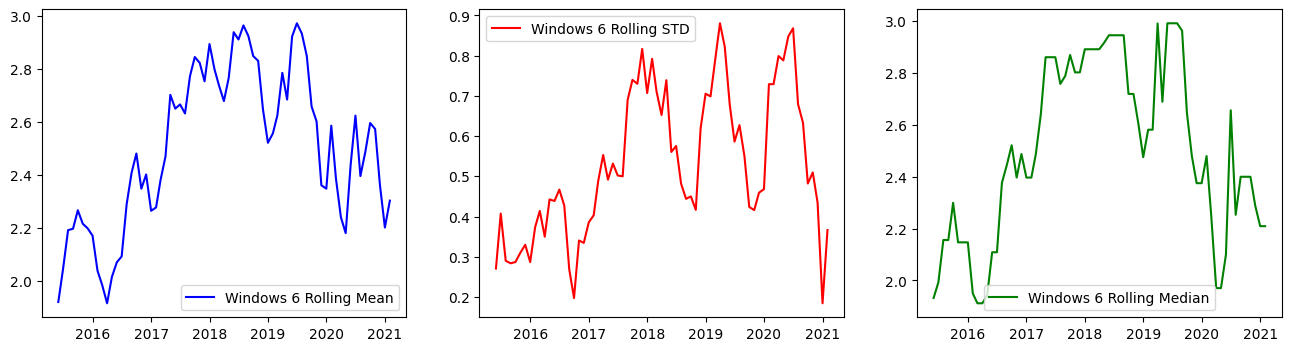

In [18]:
plot_rolling_statistics(dataframe=train, window=6, y_col="target", date_col="dates")

These picture show us two different behavior in the time series, one after 2018 and other before.

- The trend has two different behavior.
- The variability of the TS doesn't remain constant through the years.

### Is this consistent trough the years?

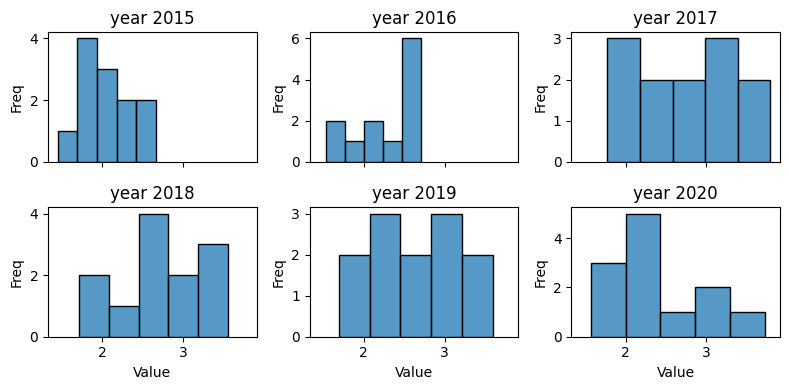

In [19]:
train_aux = train[train["dates"].dt.year < 2021]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4), sharex=True)

for ax, year in zip(axes.ravel(), train_aux["dates"].dt.year.unique()):
    sns.histplot(train_aux[train_aux["dates"].dt.year == year]["target"], ax=ax, kde=False, bins=5)  # Ajusta el número de bins según sea necesario
    ax.set_title(f"year {year}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Freq")

plt.tight_layout()
plt.show()

In [20]:
years_summary = train_aux.groupby(train_aux["dates"].dt.year)["target"].describe()
years_summary

,count,mean,std,min,25%,50%,75%,max
dates,,,,,,,,
2015,12.0,2.058491,0.322310,1.44733,1.907065,1.962750,2.288828,2.66617
2016,12.0,2.235024,0.410126,1.52566,1.969597,2.396415,2.520035,2.70222
2017,12.0,2.700688,0.659098,1.77425,2.119487,2.860655,3.066232,3.79129
2018,12.0,2.792085,0.583060,1.71206,2.519032,2.779575,3.244153,3.55745
2019,12.0,2.640533,0.625191,1.69144,2.257297,2.521290,3.095330,3.59265
2020,12.0,2.399226,0.643391,1.56953,2.002412,2.182970,2.621672,3.72629


The general distribution is not general through the years.

### What about the differenced TS?

Diferencing a TS could help us to eliminate trends and seasonality from it to make it more stationary (I am going to talk about that later).

In [21]:
train["var(t)"] = train["target"].diff(periods=1)
train_aux = train.dropna()

#### TS Plot

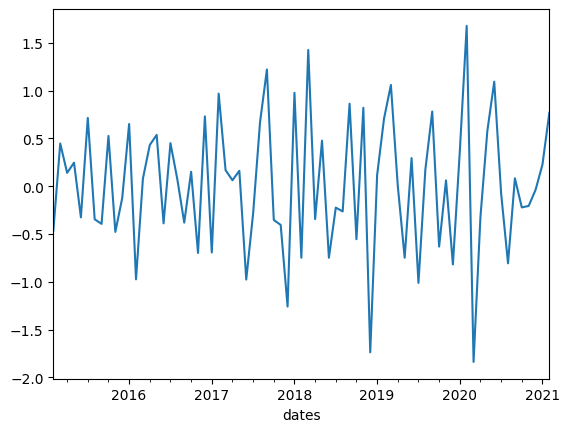

In [22]:
train_aux.set_index("dates")["var(t)"].plot();

In [23]:
train_aux.set_index("dates")["var(t)"].describe()

count    73.000000
mean      0.014463
std       0.699635
min      -1.837230
25%      -0.394400
50%       0.062060
75%       0.525340
max       1.675130
Name: var(t), dtype: float64

#### Distributions of the differenced TS - var(t)

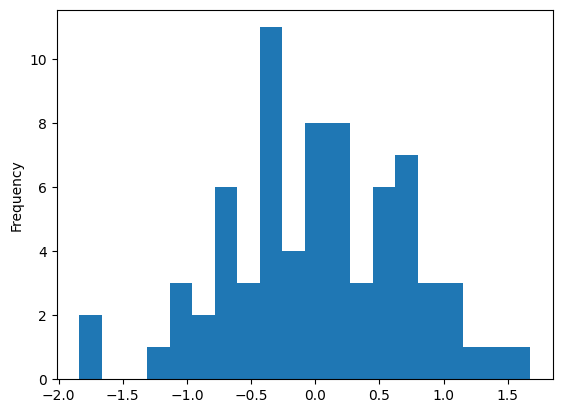

In [24]:
train_aux.set_index("dates")["var(t)"].plot(kind="hist", bins=20);

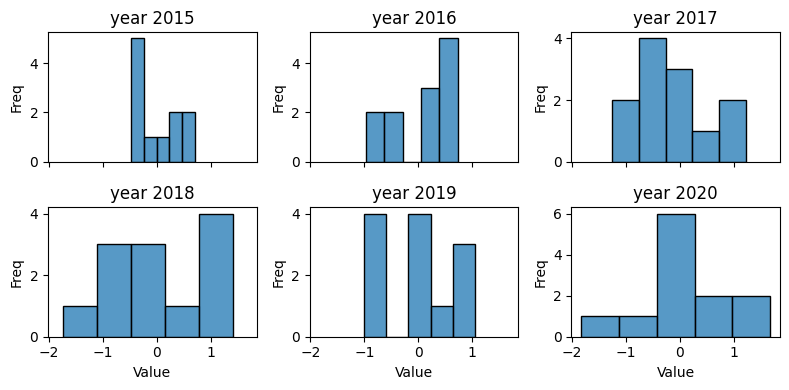

In [25]:
train_aux = train_aux[train_aux["dates"].dt.year < 2021]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4), sharex=True)

for ax, year in zip(axes.ravel(), train_aux["dates"].dt.year.unique()):
    sns.histplot(train_aux[train_aux["dates"].dt.year == year]["var(t)"], ax=ax, kde=False, bins=5)  # Ajusta el número de bins según sea necesario
    ax.set_title(f"year {year}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Freq")

plt.tight_layout()
plt.show()

In [26]:
years_summary = train_aux.groupby(train_aux["dates"].dt.year)["var(t)"].describe()
years_summary

,count,mean,std,min,25%,50%,75%,max
dates,,,,,,,,
2015,11.0,-0.005597,0.436430,-0.47781,-0.370275,-0.123150,0.345955,0.71382
2016,12.0,0.054435,0.552626,-0.97396,-0.383015,0.114640,0.471167,0.72956
2017,12.0,-0.060747,0.754792,-1.25847,-0.476982,-0.111375,0.291590,1.21966
2018,12.0,-0.005183,0.919587,-1.73655,-0.603053,-0.244005,0.830315,1.42370
2019,12.0,-0.001718,0.674791,-1.01066,-0.660885,0.087830,0.396707,1.05792
2020,12.0,0.023507,0.888763,-1.83723,-0.246480,-0.056580,0.414265,1.67513


## Is there any outlier?

I am going to calc outliers by z-scores

In [101]:
train["z_score"] = (train["target"] - train["target"].mean()) / train["target"].std()

In [110]:
print(f"Are there values up to 3 (absolute value) standard deviations from mean?: {not train[train['z_score'].abs() > 3].empty}.")
print(f"Are there values up to 2.5 (absolute value) standard deviations from mean?: {not train[train['z_score'].abs() > 2.5].empty}.")

Are there values up to 3 (absolute value) standard deviations from mean?: False.
Are there values up to 2.5 (absolute value) standard deviations from mean?: False.


As seen also in the plot no outlier or extrange values are detected.

## What is the TS decomposition?

The decomposition of a TS is important to gain insight about the trend of the TS, the seasonality and the residuals. There are two main decomposition:

1. Additive: Where each of the elements (trend, seasonality and residuals) are sumed up. TS = Trend + Seasonality + Residuals.
2. Multiplicative: Where each of the elements are multiplicated. TS = Tren * Seasonality * Residuals. This TS could be transformed into an additive one by applying a logarithmic transformation.

In [27]:
train_aux = train.set_index("dates")
train_aux = train_aux.asfreq(freq="MS")
seas_dec_add = seasonal_decompose(train_aux["target"], model="additive")
seas_dec_mul = seasonal_decompose(train_aux["target"], model="multiplicative")

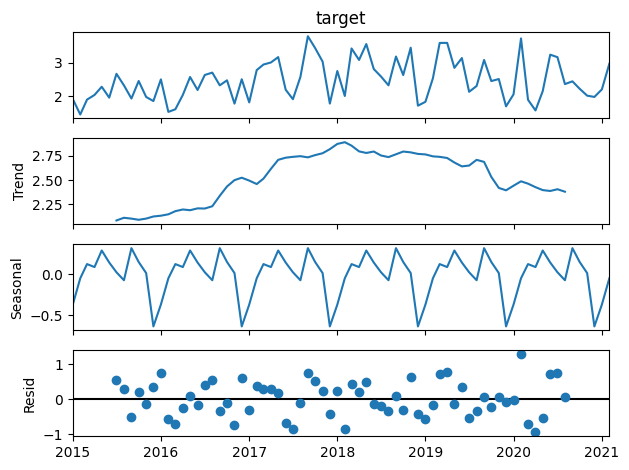

In [28]:
# Additive decomposition
fig = seas_dec_add.plot();

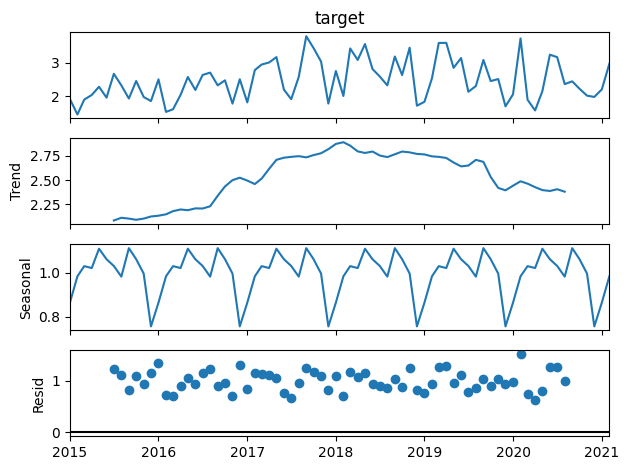

In [29]:
# Multiplicative decomposition
seas_dec_mul.plot();

Just from both previous decompositions I cannot derived is better an additive model or a multiplicative one (or a more complex seasonal decomposition like STL), so I am going to analyse the resids.

#### Additive Resids Analysis

In [30]:
additive_resids = seas_dec_add.resid.dropna()

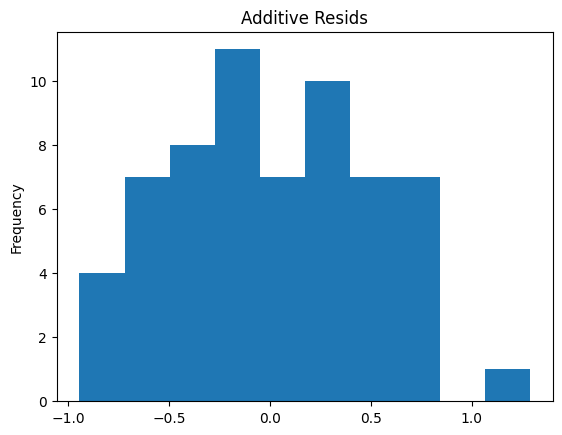

In [31]:
additive_resids.plot(kind="hist", bins=10);
plt.title("Additive Resids");

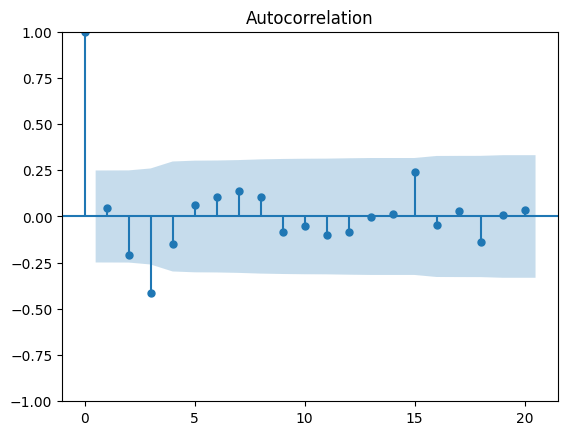

In [32]:
plot_acf(additive_resids, lags=20);

In [33]:
additive_resids_aux = additive_resids.reset_index()
additive_resids_aux.groupby(additive_resids_aux["dates"].dt.year)["resid"].agg(["mean", "std"])

,mean,std
dates,,
2015,0.131350,0.382943
2016,-0.038492,0.517692
2017,0.025724,0.495898
2018,-0.007806,0.438945
2019,-0.000530,0.437225
2020,0.074523,0.786899


In [34]:
print(f"The mean of the additive resids is {round(additive_resids.mean(), 3)} and the std is {round(additive_resids.std(), 3)}.")

The mean of the additive resids is 0.018 and the std is 0.497.


In [35]:
stat, p_value = shapiro(additive_resids)
print(f"Shapiro-Wilk Statistic: {round(stat, 2)}, P-value: {round(p_value, 2)}.")

Shapiro-Wilk Statistic: 0.98, P-value: 0.48.


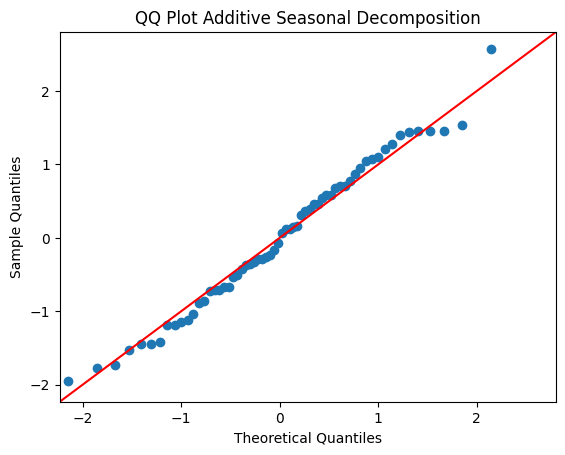

In [36]:
fig = sm.qqplot(additive_resids, line="45", fit=True)
plt.title("QQ Plot Additive Seasonal Decomposition")
plt.show()

#### Multiplicative Resids Analysis

In [37]:
multiplicative_resids = seas_dec_mul.resid.dropna()

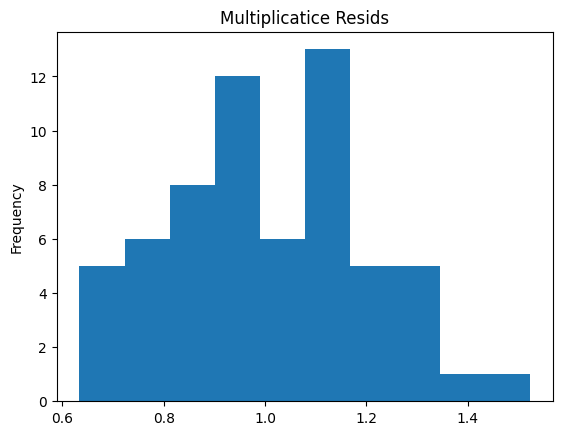

In [38]:
multiplicative_resids.plot(kind="hist", bins=10);
plt.title("Multiplicatice Resids");

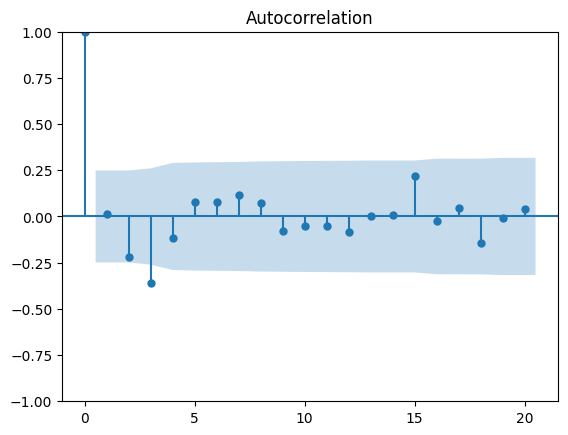

In [39]:
plot_acf(multiplicative_resids, lags=20);

In [40]:
multiplicative_resids_aux = multiplicative_resids.reset_index()
multiplicative_resids_aux.groupby(multiplicative_resids_aux["dates"].dt.year)["resid"].agg(["mean", "std"])

,mean,std
dates,,
2015,1.064379,0.152255
2016,0.996782,0.228013
2017,1.003765,0.186644
2018,0.993258,0.163126
2019,0.992495,0.169540
2020,1.031299,0.306645


In [41]:
print(f"The mean of the multiplicative resids is {round(multiplicative_resids.mean(), 3)} and the std is {round(multiplicative_resids.std(), 3)}.")

The mean of the multiplicative resids is 1.008 and the std is 0.197.


In [42]:
stat, p_value = shapiro(multiplicative_resids)
print(f"Shapiro-Wilk Statistic: {round(stat, 2)}, P-value: {round(p_value, 2)}.")

Shapiro-Wilk Statistic: 0.98, P-value: 0.44.


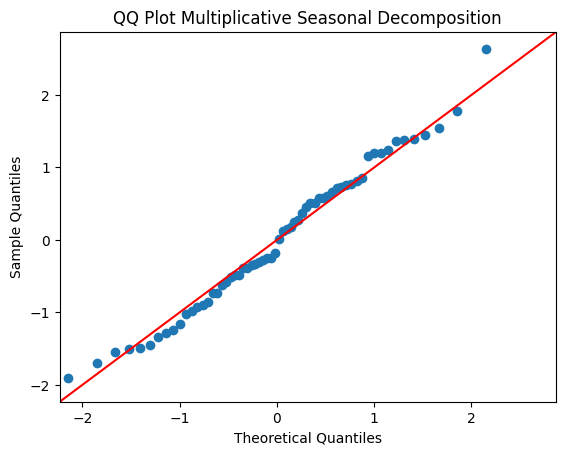

In [43]:
fig = sm.qqplot(multiplicative_resids, line="45", fit=True)
plt.title("QQ Plot Multiplicative Seasonal Decomposition")
plt.show()

After this analysis no definite decision could be done about the multiplicative or additive decompose, both have passed teh Shapiro test, both have a little autocorrelation residuals at 3, both shows a normal distribution, both extract well the trend and show a 12 month seasonality. I am going to try STL to gain understanding.

#### STL (Seasonal-Trend Decomposition using LOESS)

STL is particularly useful because it can handle any type of seasonality pattern, not just fixed periodicity, and it allows for the seasonal component to change over time.

In [44]:
stl_result = STL(train_aux["target"], seasonal=13).fit()

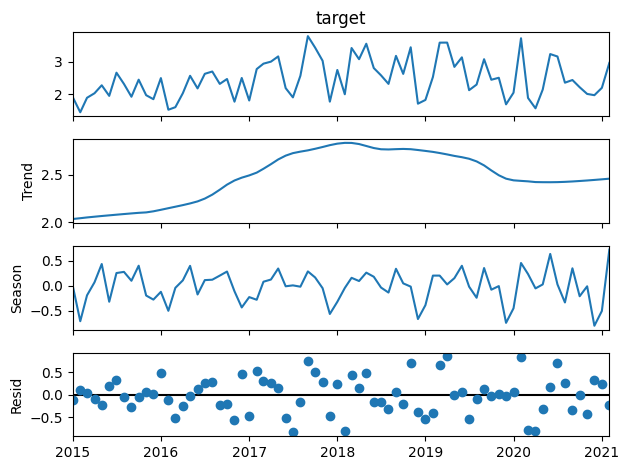

In [45]:
stl_result.plot();

In [46]:
stl_resid = stl_result.resid

In [47]:
stat, p_value = shapiro(stl_resid)
print(f"Shapiro-Wilk Statistic: {round(stat, 2)}, P-value: {round(p_value, 2)}.")

Shapiro-Wilk Statistic: 0.99, P-value: 0.69.


In [48]:
stl_resid_aux = stl_resid.reset_index()
stl_resid_aux.groupby(stl_resid_aux["dates"].dt.year)["resid"].agg(["mean", "std"])

,mean,std
dates,,
2015,-0.003938,0.169526
2016,-0.022050,0.353926
2017,0.030600,0.499842
2018,0.008906,0.421361
2019,0.006299,0.417764
2020,-0.022310,0.525896
2021,0.017439,0.328067


In [49]:
print(f"The mean of the multiplicative resids is {round(stl_resid.mean(), 4)} and the std is {round(stl_resid.std(), 4)}.")

The mean of the multiplicative resids is 0.0001 and the std is 0.3967.


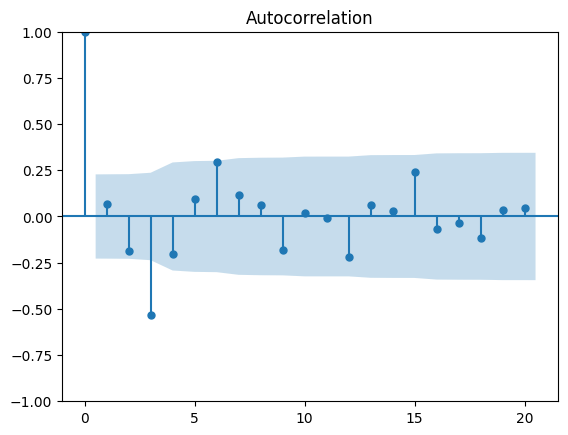

In [50]:
plot_acf(stl_resid, lags=20);

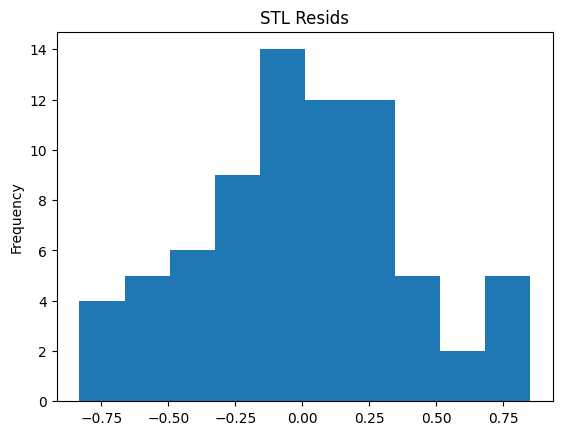

In [51]:
stl_resid.plot(kind="hist", bins=10);
plt.title("STL Resids");

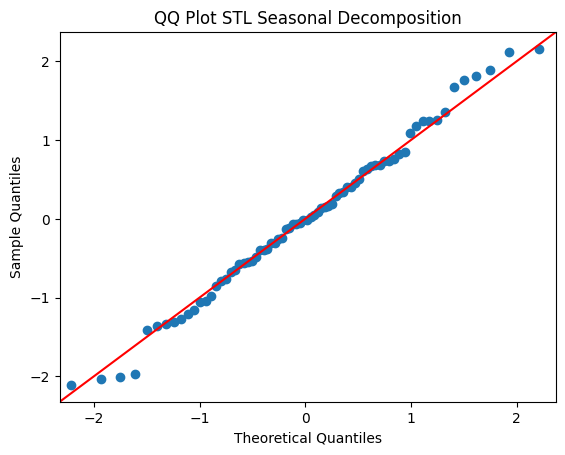

In [52]:
fig = sm.qqplot(stl_resid, line="45", fit=True)
plt.title("QQ Plot STL Seasonal Decomposition")
plt.show()

Regarding the Shapiro statistic, **this (STL) should be the best decomposition**; however, there is no definitive answer to this question. The reason is that in the complete time series (TS), we observe two distinct trends: an upward one from 2015 to 2018 and a downward one from 2018 onwards. The first trend displays more multiplicative behavior because the variance increases over the years as the level of the TS increases. However, the second trend is more additive because it shows that the level of variance remains the same as the trend decreases. Due to this, there is no unique answer to the question.

The consideration of multiple decomposition approaches also stems from the minor differences in the target values, leading to no significant dependency.

## Analysis of the ACF and PACF

In [56]:
train["target(t-1)"] = train["target"].shift(periods=1)

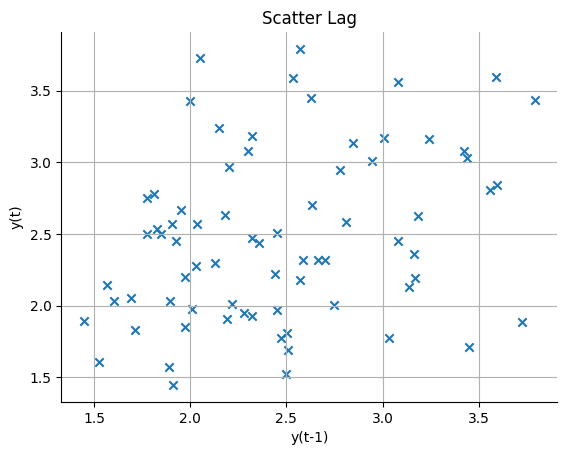

In [65]:
plt.scatter(train["target(t-1)"], train["target"], marker="x")
plt.xlabel("y(t-1)")
plt.ylabel("y(t)")
plt.title("Scatter Lag")
plt.grid(True)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

Now I am going to plot the ACF and the PACF, the difference between them is that the ACF takes into account the correlation between lags without removing latest lag information, this is related with the `q` parameter of an ARIMA model (cut-off lag ACF plot) or the parameter of the MA. And the PACF measure the correlation of a lag with other lag without the influence of latest lags so it is related with the `p` parameter in an ARIMA model (cut-off lag PACF plot) or related with the AR.

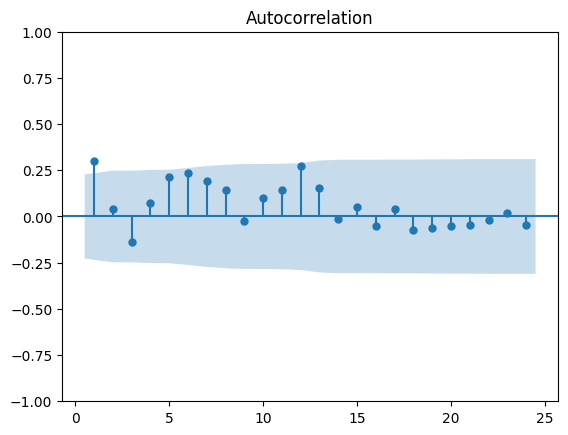

In [75]:
plot_acf(train["target"], lags=24, alpha=.05, bartlett_confint=True, zero=False);

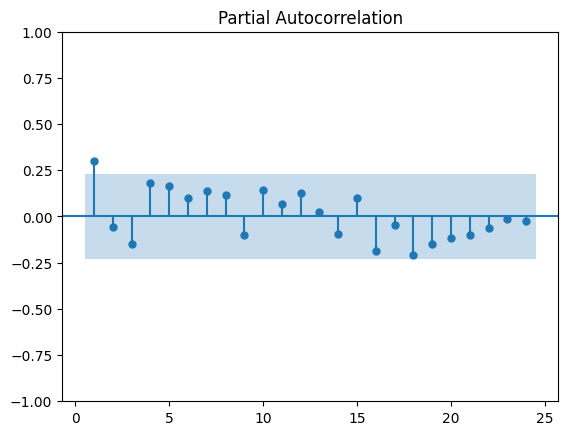

In [79]:
plot_pacf(train["target"], lags=24, alpha=.05, zero=False);

It seems that the expected parameters for MA and AR are 1, however 12 in MA could be used for predicting.

## Analysis of the stationarity

In [96]:
adf_test = adfuller(train["target"])
print(f"ADF Statistic is {adf_test[0]}.|")
print(f"P-Value is {adf_test[1]}.|")
for k, v in adf_test[4].items():
    print(f"Critical value at {k} is {v}.|")

ADF Statistic is -6.156134883240396.|
P-Value is 7.36098813916681e-08.|
Critical value at 1% is -3.5232835753964475.|
Critical value at 5% is -2.902030597326081.|
Critical value at 10% is -2.5883710883843123.|


We can reject the null hypothesis and say that the TS **is stationary** because the ADF Statistic is much lower that its critical values and the P-Value is much less that 0.05.